In [1]:
# Importe
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#import graphviz
from sklearn import tree
from matplotlib.dates import DateFormatter
import datetime as dt
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#import plotly go
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('dataset_train.csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])
#Aus Tabelle
err_1_start = dt.datetime(2022,2,28,21,53)
err_1_end = dt.datetime(2022,3,1,2,00)
err_2_start = dt.datetime(2022,3,23,14,54)
err_2_end = dt.datetime(2022,3,23,15,24)
err_3_start = dt.datetime(2022,5,30,12,00)
err_3_end = dt.datetime(2022,6,2,6,18)

# df['Label'] = np.where(
#     ((df['timestamp'] >= err_1_start) & (df['timestamp'] <= err_1_end)) |
#     ((df['timestamp'] >= err_2_start) & (df['timestamp'] <= err_2_end)) | 
#     ((df['timestamp'] >= err_3_start) & (df['timestamp'] <= err_3_end)), 1, 0)

df['Label'] = 0

#if the data is between err_1_start and err_1_end set the label to 1
df.loc[(df['timestamp'] >= err_1_start) & (df['timestamp'] <= err_1_end), 'Label'] = 1

#if the data is between err_2_start and err_2_end set the label to 2
df.loc[(df['timestamp'] >= err_2_start) & (df['timestamp'] <= err_2_end), 'Label'] = 2

#if the data is between err_3_start and err_3_end set the label to 3
df.loc[(df['timestamp'] >= err_3_start) & (df['timestamp'] <= err_3_end), 'Label'] = 3

In [129]:
from collections import Counter


class FeatureGeneration:

    def yfft(self, y):
        hanning = np.hanning(len(y))
        yf = 4*np.abs(np.fft.rfft(y*hanning))/len(y)
        return yf

    def xfft(self, blocksize, duration):
        return np.fft.rfftfreq(blocksize, duration)

    def fourier(self, blocksize, max_freq, series, name):

        #number of blocks
        nblocks = int(len(series)/blocksize)

        data = []

        X_f = self.xfft(blocksize, 1)
        X_f = X_f[X_f<max_freq]
        for i in range(nblocks):
            sr_block = series[i*blocksize:(i+1)*blocksize]
            # iserr    = df_block['Label'].sum() > BLOCKSIZE/2
            fft_amp  = self.yfft(sr_block)[:len(X_f)]
            # block_data = {'iserr': iserr}
            data.append({f'{name}_{j}':amp for j,amp in enumerate(fft_amp)})

        return pd.DataFrame(data)

    def getError(self, blocksize, series, name, label_most_common=True):
        #number of blocks
        nblocks = int(len(series)/blocksize)

        data = []

        for i in range(nblocks):
            sr_block = series[i*blocksize:(i+1)*blocksize]

            #iserr    = sr_block.sum() > blocksize/2
            if(label_most_common):
                iserr = Counter(sr_block).most_common(1)[0][0]
            else:
                iserr = sr_block.mean()
            # block_data = {'iserr': iserr}
            data.append({f'{name}':iserr})

        return pd.DataFrame(data)

    def getMean(self, blocksize, series, name):
        #number of blocks
        nblocks = int(len(series)/blocksize)

        data = []

        for i in range(nblocks):
            sr_block = series[i*blocksize:(i+1)*blocksize]

            mean    = sr_block.mean()
            # block_data = {'iserr': iserr}
            data.append({f'{name}':mean})

        return pd.DataFrame(data)

    def countPeaks(self, blocksize, series, name):
        #number of blocks
        nblocks = int(len(series)/blocksize)

        data = []

        for i in range(nblocks):
            sr_block = series[i*blocksize:(i+1)*blocksize]

            count    = sr_block[sr_block > 0.5].count()
            # block_data = {'iserr': iserr}
            data.append({f'{name}':count})

        return pd.DataFrame(data)

    def getFeatures(self, df, blocksize = 700, max_freq = 1000, label_most_common = True):
        df_features = pd.DataFrame()

        blocks = blocksize

        tp3 = self.fourier(blocks,max_freq, df['TP3'], 'TP3')
        oil = self.fourier(blocks, max_freq, df['Oil_temperature'], 'Oil')
        res = self.fourier(blocks, max_freq, df['Reservoirs'], 'Res')
        motCurr = self.fourier(blocks, max_freq, df['Motor_current'], 'MotCurr')
        h1 = self.fourier(blocks, max_freq, df['H1'], 'H1')
        LPS = self.getMean(blocks, df['LPS'], 'LPS')
        DV_pressure_peaks = self.countPeaks(blocks, df['DV_pressure'], 'DV_pressure_peaks')
        towers = self.fourier(blocks, max_freq, df['Towers'], 'Towers')

        errors = self.getError(blocks, df['Label'], 'Error', label_most_common)

        #df_features = pd.concat([df_features, tp3 ,errors, res, LPS, oil], axis=1)
        df_features = pd.concat([df_features, tp3, oil,errors, res, motCurr, h1, LPS, DV_pressure_peaks, towers], axis=1)

        return df_features

In [4]:
ft = FeatureGeneration()

dff = ft.getFeatures(df,700,1000,True)

dff

TP3_0     TP3_1     TP3_2     TP3_3     TP3_4     TP3_5     TP3_6  \
0      18.791117  9.420686  0.042790  0.009417  0.004424  0.002503  0.001062   
1      16.961119  8.494522  0.116341  0.012472  0.021313  0.007657  0.004805   
2      18.986843  9.502735  0.024888  0.014374  0.015320  0.014420  0.012216   
3      17.390615  8.760463  0.106975  0.011308  0.032160  0.023864  0.013714   
4      19.402469  9.854810  0.152783  0.116113  0.079807  0.048059  0.028508   
...          ...       ...       ...       ...       ...       ...       ...   
15385  17.279638  8.298925  0.645218  0.337393  0.174361  0.087449  0.035221   
15386  17.268179  8.653082  0.081150  0.019804  0.007695  0.004314  0.002499   
15387  18.524351  9.279373  0.084608  0.030273  0.017891  0.012533  0.009121   
15388  18.347631  9.541682  0.760843  0.367064  0.197847  0.087976  0.019082   
15389  16.841242  8.277446  0.195504  0.105904  0.066981  0.042708  0.026742   

          TP3_7     TP3_8     TP3_9  ...    H1_343    H1_344    H1_345  \
0      0.001054  0.000574  0.000476  ...  0.000126  0.000131  0.000095   
1      0.008747  0.009217  0.013566  ...  0.000346  0.000170  0.000320   
2      0.009198  0.005943  0.003045  ...  0.000733  0.000725  0.000617   
3      0.002447  0.008526  0.010652  ...  0.000122  0.000126  0.000140   
4      0.012257  0.008944  0.006183  ...  0.011182  0.011069  0.011141   
...         ...       ...       ...  ...       ...       ...       ...   
15385  0.028781  0.038013  0.039936  ...  0.016504  0.017593  0.017602   
15386  0.001503  0.001185  0.000595  ...  0.000589  0.000782  0.000610   
15387  0.006698  0.005280  0.003527  ...  0.000706  0.000733  0.000607   
15388  0.021842  0.042970  0.047736  ...  0.013536  0.010837  0.011824   
15389  0.017332  0.014356  0.013371  ...  0.008905  0.009527  0.009459   

         H1_346    H1_347    H1_348    H1_349    H1_350  LPS  \
0      0.000080  0.000111  0.000149  0.000128  0.000199  0.0   
1      0.000272  0.000740  0.000422  0.000690  0.000272  0.0   
2      0.000670  0.000484  0.000668  0.000261  0.000756  0.0   
3      0.000115  0.000130  0.000225  0.000199  0.000105  0.0   
4      0.010871  0.011047  0.011124  0.011002  0.011114  0.0   
...         ...       ...       ...       ...       ...  ...   
15385  0.016579  0.015630  0.015930  0.017105  0.017716  0.0   
15386  0.000606  0.000644  0.000693  0.000651  0.000648  0.0   
15387  0.000616  0.000423  0.000786  0.000611  0.000529  0.0   
15388  0.015245  0.017086  0.015953  0.012757  0.010736  0.0   
15389  0.008662  0.008091  0.008431  0.009134  0.009625  0.0   

       DV_pressure_peaks  
0                      0  
1                      0  
2                      2  
3                      0  
4                      1  
...                  ...  
15385                  0  
15386                  0  
15387                  0  
15388                  0  
15389                  0  

[15390 rows x 1758 columns]

In [5]:
#import kmeans and gaussian mixture
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

scaler = StandardScaler()

dffs = pd.DataFrame(scaler.fit_transform(dff),columns=dff.columns) # standardize data
X = dffs.drop(columns=['Error'], axis=1)
y = dff['Error']

#instantiate kmeans and gaussian mixture
kmeans = KMeans(n_clusters=3, random_state=0)
gmm = GaussianMixture(n_components=3, random_state=0,)

In [6]:
kmeans.fit(X)
gmm.fit(X)

c:\ProgramData\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


GaussianMixture(n_components=3, random_state=0)

In [7]:
dffs['Error']

0       -0.139417
1       -0.139417
2       -0.139417
3       -0.139417
4       -0.139417
           ...   
15385   -0.139417
15386   -0.139417
15387   -0.139417
15388   -0.139417
15389   -0.139417
Name: Error, Length: 15390, dtype: float64

In [8]:
#plot real and predicted labels
#clusters = kmeans.labels_
clusters = gmm.predict(X)
#make a line graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=X.index, y=y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=X.index, y=clusters,
                    mode='lines',
                    name='clusters'))
fig.show()

In [9]:
#indeces of error start and error end for each error
err_1_start_index = df.index[df['timestamp'] == err_1_start].tolist()[0]
err_1_end_index = df.index[df['timestamp'] == err_1_end].tolist()[0]
err_2_start_index = df.index[df['timestamp'] == err_2_start].tolist()[0]
err_2_end_index = df.index[df['timestamp'] == err_2_end].tolist()[0]
err_3_start_index = df.index[df['timestamp'] == err_3_start].tolist()[0]
err_3_end_index = df.index[df['timestamp'] == err_3_end].tolist()[0]

In [10]:
#plot labels between err_1_start and err_1_end

#lables
l = df['Label']
l = l[err_1_start_index-20000:err_1_end_index+1000]

#plot l between err_1_start and err_1_end
fig = go.Figure()
fig.add_trace(go.Scatter(x=l.index, y=l,
                    mode='lines',
                    name='l'))
fig.show()

In [11]:
#disabel warnings


In [12]:
import warnings
warnings.filterwarnings('ignore')

df_ae1 = df[err_1_start_index-200000:err_1_end_index+100000]

#feature gen
ft = FeatureGeneration()
df_ae1ff = ft.getFeatures(df_ae1,1024,1000,True)

#kmeans
scaler = StandardScaler()
#df_ae1ffs = pd.DataFrame(scaler.fit_transform(df_ae1ff),columns=df_ae1ff.columns) # standardize data

X = df_ae1ff.drop(columns=['Error'], axis=1)
y = df_ae1ff['Error']

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)

gausM = GaussianMixture(n_components=2, random_state=0)
gausM.fit(X)

# #dbscan
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=0.3, min_samples=10)
# dbscan.fit(X)



#plot real and predicted labels
# clusters = kmeans.labels_
clusters = gausM.predict(X)
#make a line graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=X.index, y=y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=X.index, y=clusters,
                    mode='lines',
                    name='clusters'))
fig.show()



In [13]:
import warnings
warnings.filterwarnings('ignore')

df_ae1 = df[err_2_start_index-6000:err_2_end_index+6000]

#feature gen
ft = FeatureGeneration()
df_ae1ff = ft.getFeatures(df_ae1,700,1000,True)

#kmeans
scaler = StandardScaler()
#df_ae1ffs = pd.DataFrame(scaler.fit_transform(df_ae1ff),columns=df_ae1ff.columns) # standardize data

X = df_ae1ff.drop(columns=['Error'], axis=1)
y = df_ae1ff['Error']

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)

# gausM = GaussianMixture(n_components=2, random_state=0)
# gausM.fit(X)

# #dbscan
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=0.3, min_samples=10)
# dbscan.fit(X)



#plot real and predicted labels
# clusters = kmeans.labels_
clusters = kmeans.labels_
#make a line graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=X.index, y=y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=X.index, y=clusters,
                    mode='lines',
                    name='clusters'))
fig.show()



In [14]:
#calculates the percentage of coverage between two lists, also counts if the values are inversed
def scoreUnsupervised(y_pred, y_true):
    #calculate coverage
    coverage = 0
    for i in range(len(y_pred)):
        if(y_pred[i] == -1):
            continue
        if y_pred[i] == y_true[i]:
            coverage += 1
    coverage = coverage/len(y_pred)
    
    #calculate coverage if y_pred and y_true are inversed
    coverage_inv = 0
    for i in range(len(y_pred)):
        if(y_pred[i] == -1):
            continue
        if y_pred[i] != y_true[i]:
            coverage_inv += 1
    coverage_inv = coverage_inv/len(y_pred)
    
    #return the higher coverage
    if coverage > coverage_inv:
        return coverage
    else:
        return coverage_inv


In [15]:
import warnings
warnings.filterwarnings('ignore')
#400000
df_ae1 = df[err_3_start_index-40_000_000:err_3_end_index+1000000]

#feature gen
ft = FeatureGeneration()
df_ae1ff = ft.getFeatures(df_ae1,2000,0.5,True)

#kmeans
scaler = StandardScaler()
df_ae1ffs = pd.DataFrame(scaler.fit_transform(df_ae1ff),columns=df_ae1ff.columns) # standardize data

X = df_ae1ff.drop(columns=['Error'], axis=1)
y = df_ae1ff['Error']

#kmeans = KMeans(n_clusters=2, random_state=0,algorithm="elkan")
#kmeans.fit(X)

gausM = GaussianMixture(n_components=2, random_state=0)
gausM.fit(X)

# #dbscan
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=70, min_samples=10, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=-1)

# scores = []
# for i in range(20,100):
#     for j in range(1,100): 
#         dbscan = DBSCAN(eps=j/25, min_samples=i, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=-1)
#         dbscan.fit(X)
#         clusters = dbscan.labels_
#         cov = scoreUnsupervised(clusters, y)
#         print(i, j/25, cov)
#         scores.append([i, j/25,cov])


# dbscan.fit(X)
# print(scoreUnsupervised(dbscan.labels_, y))


#plot real and predicted labels
# clusters = kmeans.labels_
clusters = gausM.predict(X)
#make a line graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=X.index, y=y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=X.index, y=clusters,
                    mode='lines',
                    name='clusters'))
fig.show()



In [ ]:
assert False    

In [137]:
df_normal = dff[dff['Error'] == 0]
df_error1 = dff[dff['Error'] == 1]
df_error2 = dff[dff['Error'] == 2]
df_error3 = dff[dff['Error'] == 3]
df_erroralg = dff[dff['Error'] != 0]

In [140]:
df_normal_stat = df_normal.agg(['mean', 'std'])
df_error1_stat = df_error1.agg(['mean', 'std'])
df_error2_stat = df_error2.agg(['mean', 'std'])
df_error3_stat = df_error3.agg(['mean', 'std'])
df_erralg_stat = df_erroralg.agg(['mean', 'std'])

x = ((df_error1_stat.loc['mean'] -df_normal_stat.loc['mean'])/df_normal_stat.loc['std']).abs()


In [141]:
px.bar(y=x, x=x.index)

In [8]:
x = dff['Oil_0']
y = dff['Error']

In [9]:
px.scatter(x=y, y=x)

In [200]:
ft = FeatureGeneration()

dff = ft.getFeatures(df,1024,1000,True)

In [201]:
from sklearn.mixture import GaussianMixture

In [207]:
oil_colls = [c for c in dff.columns if c.startswith('Oil')]#[35:200]
tp3_colls = [c for c in dff.columns if c.startswith('TP3')]#[20:]
h1_colls = [c for c in dff.columns if c.startswith('H1')]#[0:2]
res_cols = [c for c in dff.columns if c.startswith('Res')]#[0:2]
mot_curr_colls = [c for c in dff.columns if c.startswith('MotorCurr')]
LPS_colls = [c for c in dff.columns if c.startswith('LPS')]
towers_colls = [c for c in dff.columns if c.startswith('Towers')]


h1 = h1_colls[0:7] + h1_colls[500:]
oil = oil_colls[30:760]
tp3 = tp3_colls[300:]
res = res_cols[0:2]
towers = towers_colls[0:2] + towers_colls[450:]


#filter_cols = h1_colls[0:23] + h1_colls[600:] + mot_curr_colls[3:250] + oil_colls[25:] + res_cols[0:60] + tp3_colls[30:]

#hohe 1er weniger  0er -> rauschen
#filter_cols = oil_colls[30:] + tp3_colls[170:] + res_cols[0:3]

#res 0:1 gibt fehler 3 100% treffer, aber gibt auch viel vor fehler 3 treffer, weil res vorher auch shcon stratk steigt und da dc offset schon viel höher ost
filter_cols = h1 + oil + tp3 + towers + res


#kmeans
#kmeans = KMeans(n_clusters=4, random_state=0)
#kmeans.fit(dff[filter_cols])

gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(dff[filter_cols])


#plot real and predicted labels
#clusters = kmeans.labels_
clusters = gmm.predict(dff[filter_cols])
#make a line graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=dff.index, y=dff['Error'],
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=dff.index, y=clusters,
                    mode='markers',
                    name='clusters',
                    marker=dict(
                        size=1.5,
                   )))
fig.show()

In [203]:
df_res = pd.DataFrame({'Label':dff['Error'], 'Cluster':clusters})

df_res['IsError'] = (df_res['Label'] != 0).astype(int)

In [204]:
sens = ((df_res["Cluster"] == 1) & (df_res["IsError"] == 1)).sum()/(df_res["IsError"]==1).sum()
sens

0.9710144927536232

201 9468 846 6


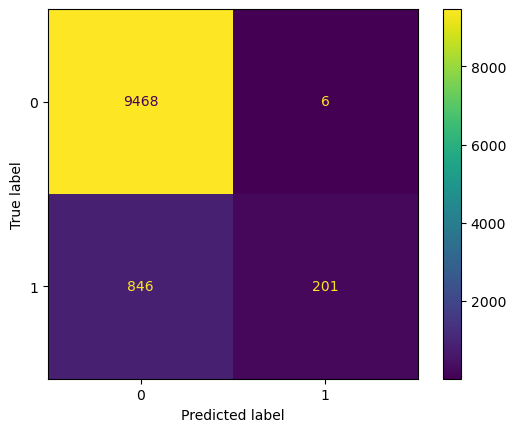

In [205]:
TP = ((df_res["Cluster"] == 1) & (df_res["IsError"] == 1)).sum()
TN = ((df_res["Cluster"] == 0) & (df_res["IsError"] == 0)).sum()
FP = ((df_res["Cluster"] == 1) & (df_res["IsError"] == 0)).sum()
FN = ((df_res["Cluster"] == 0) & (df_res["IsError"] == 1)).sum()

print(TP, TN, FP, FN)

#make confusion matrix from TP TN FP FN
confusion_matrix = np.array([[TN, FN], [FP, TP]])
#plot confusion matrix with matplotlib ploty
ConfusionMatrixDisplay(confusion_matrix).plot()

In [199]:
sens = ((df_res["Cluster"] == 1) & (df_res["IsError"] == 1)).sum()/(df_res["IsError"]==1).sum()
spec = ((df_res["Cluster"] == 0) & (df_res["IsError"] == 0)).sum()/(df_res["IsError"]==0).sum()

print(sens, spec)


0.9204819277108434 0.5447229359577254


0.37293729372937295 0.9950288327699344

oil_colls = [c for c in dff.columns if c.startswith('Oil')][150:]
tp3_colls = [c for c in dff.columns if c.startswith('TP3')][150:]
0.8415841584158416 0.9905879233777424

In [208]:
dff2 = dff.copy()

exclude      = [c for c in dff2.columns if len(c.split("_")) != 2 and c != "Error"]
dff2         = dff2.drop(columns=exclude, axis=1)

#col_map      = [tuple(c.split("_")) for c in dff2.columns]
#dff2.columns = pd.MultiIndex.from_tuples(col_map)

In [209]:
dff2_err    = dff2[dff2['Error'] != 0].drop(columns=['Error'], axis=1)
dff2_normal = dff2[dff2['Error'] == 0].drop(columns=['Error'], axis=1)

dff2_err_stat    = dff2_err.agg(['mean', 'std'])
dff2_normal_stat = dff2_normal.agg(['mean', 'std', "min", "max"])
dff2_sig         = ((dff2_err_stat.loc['mean'] -dff2_normal_stat.loc['mean'])/dff2_normal_stat.loc['std']).agg([abs]).T

col_map          = [(c.split("_")[0], int(c.split("_")[1])) for c in dff2_sig.columns]
dff2_sig.columns = pd.MultiIndex.from_tuples(col_map)

dff2_sig         = dff2_sig.stack(level=0).loc["abs"]


In [210]:
dff2_sig.T

H1   MotCurr       Oil       Res       TP3    Towers
0    0.579349  0.134320  0.126946  0.842917  0.833374  0.431606
1    0.408608  0.188665  0.129459  0.839864  0.590070  0.289405
2    0.425028  0.186805  0.431526  0.034042  0.192282  0.396311
3    0.351167  0.059353  0.634278  0.289871  0.188057  0.310977
4    0.300527  0.208850  1.248418  0.258096  0.288026  0.236578
..        ...       ...       ...       ...       ...       ...
508  0.475361  0.394576  2.811018  0.058110  2.006220  0.105955
509  0.458822  0.403874  2.814604  0.012146  2.004806  0.062922
510  0.342494  0.327615  2.674089  0.030771  1.772362  0.032069
511  0.338786  0.236022  2.806721  0.024515  1.913787  0.022168
512  0.344225  0.176355  2.494766  0.077987  2.001754  0.018944

[513 rows x 6 columns]

In [211]:
dff2_sig = dff2_sig.T

dff2_sig = pd.DataFrame(MinMaxScaler().fit_transform(dff2_sig), columns=dff2_sig.columns, index=dff2_sig.index)	
dff2_sig = dff2_sig.T

In [212]:
dff2_sig

0         1         2         3         4         5         6    \
H1       1.000000  0.705112  0.733471  0.605905  0.518443  0.466963  0.250466   
MotCurr  0.130205  0.197307  0.195009  0.037640  0.222229  0.161552  0.673805   
Oil      0.000000  0.000721  0.087308  0.145427  0.321471  0.332491  0.404620   
Res      1.000000  0.996378  0.040321  0.343846  0.306146  0.364315  0.431825   
TP3      0.332623  0.207214  0.002178  0.000000  0.051529  0.037876  0.212391   
Towers   1.000000  0.670127  0.918124  0.720171  0.547583  0.461299  0.387875   

              7         8         9    ...       503       504       505  \
H1       0.105689  0.628808  0.812689  ...  0.433668  0.472335  0.649425   
MotCurr  0.341240  0.745138  0.741036  ...  0.427531  0.341981  0.462209   
Oil      0.397080  0.552198  0.687570  ...  0.744795  0.727155  0.713587   
Res      0.334129  0.393161  0.387583  ...  0.172209  0.070979  0.096763   
TP3      0.371778  0.495696  0.677153  ...  0.847908  0.855540  0.919228   
Towers   0.146908  0.605974  0.428280  ...  0.132283  0.089943  0.022549   

              506       507       508       509       510       511       512  
H1       0.619692  0.741348  0.820401  0.791836  0.590926  0.584521  0.593916  
MotCurr  0.481128  0.402440  0.451553  0.463033  0.368873  0.255780  0.182107  
Oil      0.759979  0.703050  0.769391  0.770419  0.730141  0.768160  0.678738  
Res      0.017626  0.188086  0.068875  0.014342  0.036439  0.029018  0.092459  
TP3      0.914883  0.798575  0.937156  0.936427  0.816616  0.889513  0.934854  
Towers   0.174963  0.002119  0.244569  0.144743  0.073172  0.050203  0.042724  

[6 rows x 513 columns]

In [213]:
# px.imshow(dff2_sig.astype(int))
px.imshow(dff2_sig)



In [214]:


dff2_normal_stat2   = dff2_normal_stat.copy()
col_map             = [(c.split("_")[0], int(c.split("_")[1])) for c in dff2_normal_stat2.columns]
dff2_normal_stat2.columns = pd.MultiIndex.from_tuples(col_map)

dff2_normal_gauss = dff2_normal_stat2.stack(level=0).T


In [215]:
df_xyzz = dff2_normal_gauss.stack(level=1).reset_index()
df_xyzz["base"]       = df_xyzz["mean"]-2*df_xyzz["std"]
df_xyzz["y"]          = df_xyzz["mean"]+2*df_xyzz["std"]    - df_xyzz["base"] 
df_xyzz["error_y"]    = df_xyzz["max"]  - df_xyzz["mean"]   - 2*df_xyzz["std"]
df_xyzz["error_y_m"]  = df_xyzz["mean"] +  2*df_xyzz["std"] - df_xyzz["min"]
df_xyzz["text"]  = df_xyzz.apply(lambda c: f"Min: {c['min']:.2f} | Mean: {c['mean']:.2f} | Max: {c['max']:.2f} | Std: {c['std']:.2f}", axis=1)
px.bar(df_xyzz, x="level_0", base="base", y="y", error_y="error_y", error_y_minus="error_y_m", color="level_1", hover_name="text")

In [112]:
df_xyzz[(df_xyzz["level_1"] == "H1") & (df_xyzz["level_0"] == 0)]

level_0 level_1        max      mean       min       std       base  \
0        0      H1  18.706173  15.51944  0.000101  1.418528  12.682384   

          y   error_y  error_y_m  
0  5.674111  3.186733  15.519339